## 6.4: Supervised Machine Learning: Regression

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Reset the maximum number of columns to display to default (all columns)

pd.set_option('display.max_columns', None)

In [3]:
# This option ensures that the graphs you create are displayed within the notebook without the need to "call" them specifically.

%matplotlib inline

In [4]:
# Defining the path to datasets

path = r'C:\Users\efens\cf_tasks\2023-08 Steam Analysis'

## 00. Preparing dataframe for analysis

In [5]:
# Importing project data "steam_merged"

steam_merged = pd.read_csv(os.path.join(path, '02 Data', '022 Prepared Data', 'steam_merged.csv'))

#### Selecting important columns for further analysis

H1_A: An increase in the number of game owners is positively correlated with a higher quantity of positive online reviews for the game in Steam.

H1_B: An increase in the number of game owners is positively correlated with a higher quantity of negative online reviews for the game in Steam.

H2_A: Games with age restrictions have a significantly larger number of owners compared to games without age restrictions.

H2_B: Games without age restrictions exhibit a significantly longer average playtime than games with age restrictions, indicating a potential difference in player engagement.

In [6]:
steam_merged.columns

Index(['appid', 'name', 'release_date', 'english', 'developer', 'publisher',
       'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags',
       'achievements', 'positive_ratings', 'negative_ratings',
       'average_playtime', 'median_playtime', 'owners', 'price', 'price_eur',
       'owners_min', 'owners_max', 'owners_avg', 'gameplay_type', 'dev_year',
       'country', 'city', 'administrative_division'],
      dtype='object')

In [7]:
steam_merged.head(3)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,price_eur,owners_min,owners_max,owners_avg,gameplay_type,dev_year,country,city,administrative_division
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19,8.3404,10000000,20000000,15000000.0,Multi-Player,1996.0,United States,Kirkland,Washington
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99,4.6284,5000000,10000000,7500000.0,Multi-Player,1996.0,United States,Kirkland,Washington
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99,4.6284,5000000,10000000,7500000.0,Multi-Player,1996.0,United States,Kirkland,Washington


#### Creating the dataframe with the following columns

- name, required_age, positive_ratings, negative_ratings, average_playtime, owners_avg
- creating a new column with the name age_restrictions (0 - no, 1 yes)

In [8]:
steam_merged[['required_age']].value_counts()

required_age
0               26632
18                311
16                194
12                 73
7                  12
3                  11
dtype: int64

In [9]:
# Creating a new column 'age_restrictions' where all values equal to 0 = 0 and all others = 1

steam_merged['age_restrictions'] = 1  # Initialize the new column with a default value of 1

for index, row in steam_merged.iterrows():
    if row['required_age'] == 0:
        steam_merged.at[index, 'age_restrictions'] = 0  # Set the value to 0 if required_age is equal to 0

# 0 = without age restrictions
# 1 = with age restrictions

In [10]:
steam_merged[['age_restrictions']].value_counts()

age_restrictions
0                   26632
1                     601
dtype: int64

In [11]:
# Creating a new dataframe

steam_ml = steam_merged[['name', 'age_restrictions', 'positive_ratings','negative_ratings', 'average_playtime', 'owners_avg']]

In [12]:
steam_ml.head()

,name,age_restrictions,positive_ratings,negative_ratings,average_playtime,owners_avg
0,Counter-Strike,0,124534,3339,17612,15000000.0
1,Team Fortress Classic,0,3318,633,277,7500000.0
2,Day of Defeat,0,3416,398,187,7500000.0
3,Deathmatch Classic,0,1273,267,258,7500000.0
4,Half-Life: Opposing Force,0,5250,288,624,7500000.0


In [13]:
steam_ml.shape

(27233, 6)

#### Cleaning

In [14]:
steam_ml.dtypes

name                 object
age_restrictions      int64
positive_ratings      int64
negative_ratings      int64
average_playtime      int64
owners_avg          float64
dtype: object

In [15]:
# Checking missing values

missing_steam = steam_ml.isnull().sum()
missing_steam

name                0
age_restrictions    0
positive_ratings    0
negative_ratings    0
average_playtime    0
owners_avg          0
dtype: int64

In [16]:
# Checking for duplicates

dups = steam_ml[steam_ml.duplicated()]

In [17]:
dups

,name,age_restrictions,positive_ratings,negative_ratings,average_playtime,owners_avg
31,Darwinia,0,472,158,182,750000.0
33,Uplink,0,1602,152,65,750000.0
35,DEFCON,0,2057,344,80,750000.0
37,Multiwinia,0,368,75,121,750000.0
126,Garry's Mod,0,363721,16433,12422,15000000.0
...,...,...,...,...,...,...
16901,HoloLAB Champions,0,6,0,0,10000.0
17952,NBA 2K Playgrounds 2,0,123,73,0,10000.0
19718,40 Winks,0,3,7,0,10000.0
20700,Assetto Corsa Competizione,0,1744,278,0,75000.0


In [18]:
# Removing duplicates

steam_ml_clean = steam_ml.drop_duplicates()

In [19]:
dups = steam_ml_clean[steam_ml_clean.duplicated()]
dups

,name,age_restrictions,positive_ratings,negative_ratings,average_playtime,owners_avg


In [20]:
# Change the format of the values visualization

pd.options.display.float_format = '{:.2f}'.format

# Exploring statistical values

steam_ml_clean.describe()

,age_restrictions,positive_ratings,negative_ratings,average_playtime,owners_avg
count,27075.00,27075.00,27075.00,27075.00,27075.00
mean,0.02,1000.56,211.03,149.80,134090.49
std,0.15,18988.72,4284.94,1827.04,1328088.58
min,0.00,0.00,0.00,0.00,10000.00
25%,0.00,6.00,2.00,0.00,10000.00
50%,0.00,24.00,9.00,0.00,10000.00
75%,0.00,126.00,42.00,0.00,35000.00
max,1.00,2644404.00,487076.00,190625.00,150000000.00


- There are extreme values in almost every column.

In [21]:
steam_ml_clean.shape

(27075, 6)

#### Extrem evalues check

<Axes: xlabel='positive_ratings', ylabel='Count'>

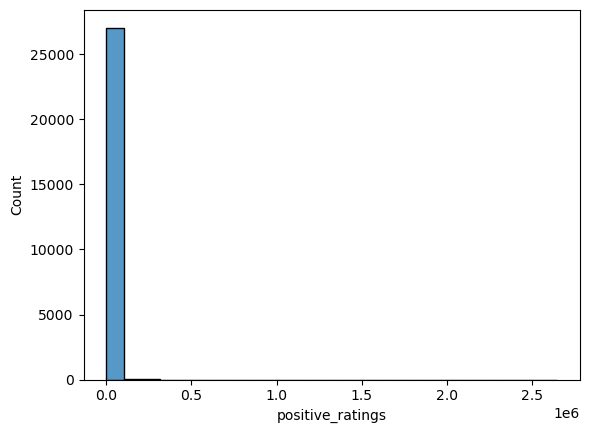

In [22]:
## Variable positive_ratings

# Shows extreme values
sns.histplot(steam_ml_clean['positive_ratings'], bins=25)

# Some of the outliers in the high values may need to be removed, but let's try without doing so first.

<Axes: xlabel='negative_ratings', ylabel='Count'>

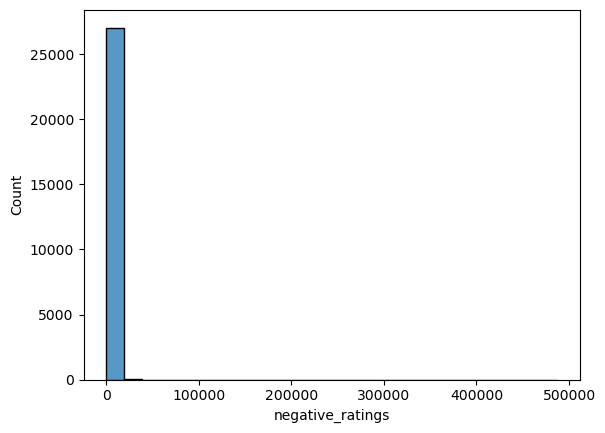

In [23]:
## Variable negative_ratings

sns.histplot(steam_ml_clean['negative_ratings'], bins=25) # Shows extreme values

<Axes: xlabel='average_playtime', ylabel='Count'>

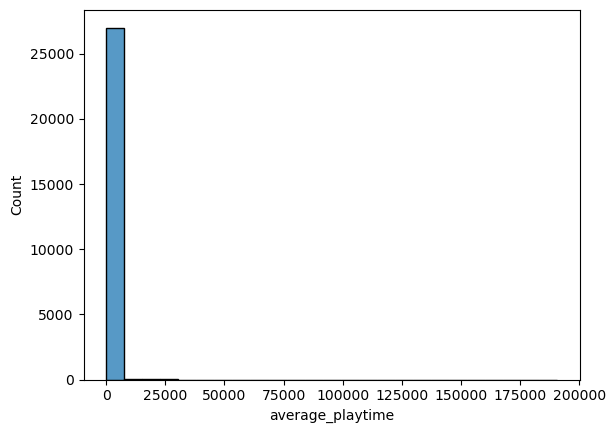

In [24]:
## Variable average_playtime

sns.histplot(steam_ml_clean['average_playtime'], bins=25) # Shows extreme values

<Axes: xlabel='owners_avg', ylabel='Count'>

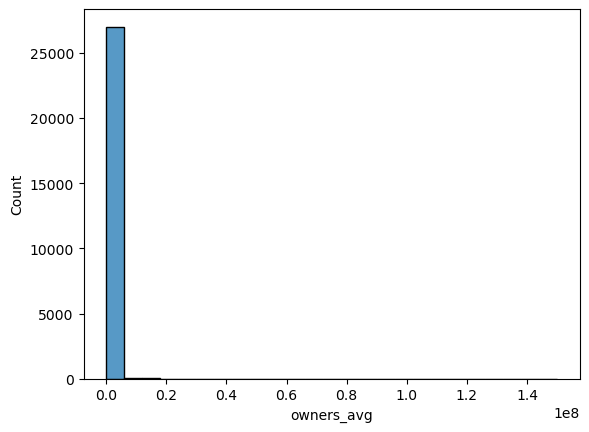

In [25]:
## Variable average_playtime

sns.histplot(steam_ml_clean['owners_avg'], bins=25) # Shows extreme values

In [26]:
steam_ml_clean[['average_playtime']].value_counts()

average_playtime
0                   20905
1                     156
3                      73
2                      58
9                      56
                    ...  
1177                    1
1178                    1
1180                    1
1195                    1
190625                  1
Length: 1345, dtype: int64

In [27]:
steam_ml_clean[['negative_ratings']].value_counts()

negative_ratings
0                   2906
1                   2748
2                   1907
3                   1503
4                   1182
                    ... 
1180                   1
1186                   1
1188                   1
1195                   1
487076                 1
Length: 1492, dtype: int64

- Based on the frequency distribution of the data, it appears that they are not suitable for conducting regression analysis due to the presence of numerous outliers. 

- In order to achieve a more accurate analysis, I intend to exclude users from the sample who have added the game to their library but have never launched it. This exclusion may result in a more normalized distribution of the data.

In [28]:
# Creating a subset with active owners where average_playtime > 0

steam_ml_active = steam_ml_clean[steam_ml_clean['average_playtime'] != 0]

In [29]:
steam_ml_active.shape

(6170, 6)

In [30]:
steam_ml_active.describe()

,age_restrictions,positive_ratings,negative_ratings,average_playtime,owners_avg
count,6170.00,6170.00,6170.00,6170.00,6170.00
mean,0.05,4181.49,858.13,657.37,527782.01
std,0.23,39613.43,8945.58,3783.67,2745237.57
min,0.00,0.00,0.00,1.00,10000.00
25%,0.00,106.00,38.00,77.00,35000.00
50%,0.00,408.00,113.00,222.00,150000.00
75%,0.00,1704.75,365.00,365.00,350000.00
max,1.00,2644404.00,487076.00,190625.00,150000000.00


<Axes: xlabel='average_playtime', ylabel='Count'>

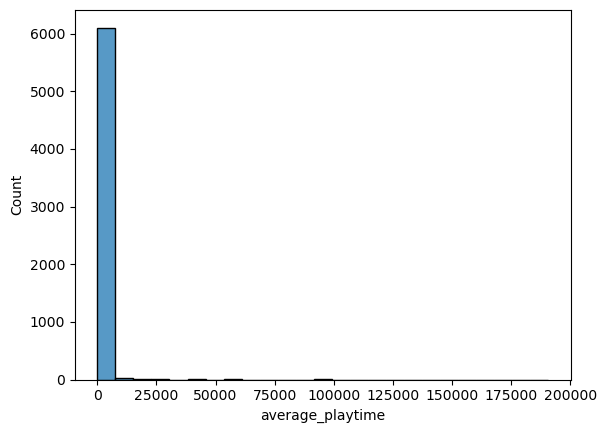

In [31]:
## Variable average_playtime

sns.histplot(steam_ml_active['average_playtime'], bins=25) # Shows extreme values

#### What are Top-10 games with average playtime > 1000?

In [32]:
top_10_games = steam_ml_active[steam_ml_active['average_playtime'] > 1000].nlargest(10, 'average_playtime')

In [33]:
top_10_games[['name', 'average_playtime']].sort_values(by='average_playtime', ascending=True)

,name,average_playtime
9054,Screeps,38805
2098,Fantasy Grounds,43074
23566,懒人修仙传,43632
2516,X-Plane 11,44169
4078,Shroud of the Avatar: Forsaken Virtues,54618
4037,Boundless,55204
9105,PRICE,63481
6135,The Secret of Tremendous Corporation,95242
1526,The Banner Saga: Factions,95245
9337,The Abbey of Crime Extensum,190625


- Remove the outlier / 9337	The Abbey of Crime Extensum	190625

In [34]:
# Remove the outlier 

steam_ml_active_clean = steam_ml_active[steam_ml_active['average_playtime'] != 190625]

In [35]:
steam_ml_active_clean[['average_playtime']].describe()

,average_playtime
count,6169.00
mean,626.58
std,2909.76
min,1.00
25%,77.00
50%,222.00
75%,365.00
max,95245.00


- It looks a little better, but it's still highly scattered with large values. 

- I can assume, that average values vere counted including null and very large values. For that reason the data doesn't appear to be reliable.

## 02. Data preparation for regression analysis

### H1_A: An increase in the number of game owners is positively correlated with a higher quantity of positive online reviews for the game in Steam.

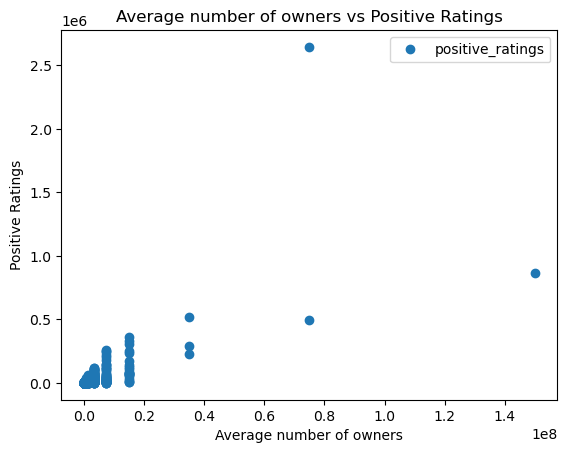

In [36]:
# Create a scatterplot using matplotlib for another look at how the chosen variables plot against each other.

steam_ml_active_clean.plot(x = 'owners_avg', y='positive_ratings',style='o') # The style option creates a scatterplot; without it, we only have lines.
plt.title('Average number of owners vs Positive Ratings')  
plt.xlabel('Average number of owners')  
plt.ylabel('Positive Ratings')  
plt.show()

In [37]:
# Reshape the variables into NumPy arrays and put them into separate objects.

X1 = steam_ml_active_clean['owners_avg'].values.reshape(-1,1)
y1 = steam_ml_active_clean['positive_ratings'].values.reshape(-1,1)

In [38]:
X1

array([[1.5e+07],
       [7.5e+06],
       [7.5e+06],
       ...,
       [1.0e+04],
       [7.5e+04],
       [1.0e+04]])

In [39]:
y1

array([[124534],
       [  3318],
       [  3416],
       ...,
       [   619],
       [   651],
       [   221]], dtype=int64)

In [40]:
# Split data into a training set and a test set.

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=0)

## 03. Regression analysis

In [41]:
# Create a regression object.

regression = LinearRegression()  # This is the regression object, which will be fit onto the training set.

In [42]:
# Fit the regression object onto the training set.

regression.fit(X1_train, y1_train)

LinearRegression()

In [43]:
# Predict the values of y using X.

y1_predicted = regression.predict(X1_test)

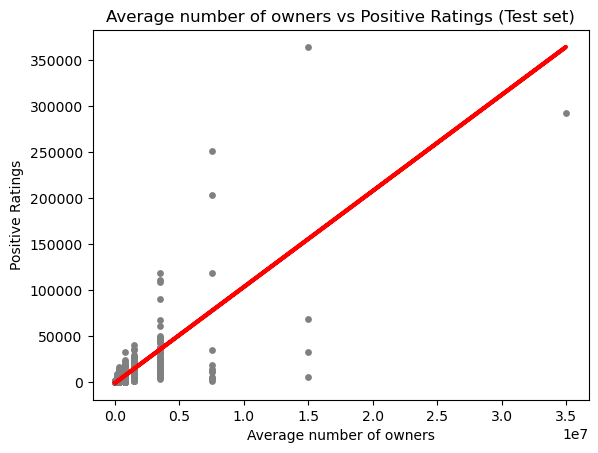

In [44]:
# Create a plot that shows the regression line from the model on the test set.

plot_test = plt
plot_test.scatter(X1_test, y1_test, color='gray', s = 15)
plot_test.plot(X1_test, y1_predicted, color='red', linewidth =3)
plot_test.title('Average number of owners vs Positive Ratings (Test set)')
plot_test.xlabel('Average number of owners')
plot_test.ylabel('Positive Ratings')
plot_test.show()

In [45]:
# Create objects that contain the model summary statistics.

rmse = mean_squared_error(y1_test, y1_predicted) # This is the mean squared error
r2 = r2_score(y1_test, y1_predicted) # This is the R2 score. 

In [46]:
# Print the model summary statistics. This is where you evaluate the performance of the model.

print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[0.01044347]]
Mean squared error:  130198550.7375091
R2 score:  0.4559240973444483


In [47]:
# Create a dataframe comparing the actual and predicted values of y.

data_1 = pd.DataFrame({'Actual': y1_test.flatten(), 'Predicted': y1_predicted.flatten()})
data_1.head(30)

,Actual,Predicted
0,81,-882.44
1,410,-882.44
2,19,-882.44
3,1735,2407.26
4,62,-1143.53
5,5844,14417.25
6,3825,14417.25
7,242,318.56
8,66,318.56
9,44810,35304.20


#### Compare how the regression fits the training set

In [48]:
# Predict.

y1_predicted_train = regression.predict(X1_train) # This is predicting X_train!

In [49]:
rmse = mean_squared_error(y1_train, y1_predicted_train)
r2 = r2_score(y1_train, y1_predicted_train)

In [50]:
print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[0.01044347]]
Mean squared error:  1052838263.8143122
R2 score:  0.5077707740153197


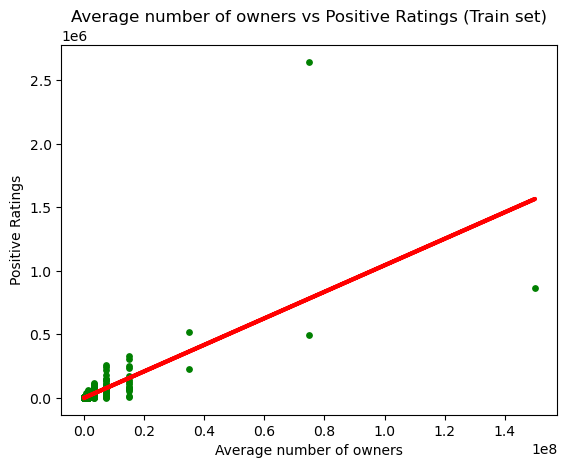

In [51]:
# Visualizing the training set results.

plot_test = plt
plot_test.scatter(X1_train, y1_train, color='green', s = 15)
plot_test.plot(X1_train, y1_predicted_train, color='red', linewidth =3)
plot_test.title('Average number of owners vs Positive Ratings (Train set)')
plot_test.xlabel('Average number of owners')
plot_test.ylabel('Positive Ratings')
plot_test.show()

## 04. Comments and explanations

- Thus, the model I trained has some predictive power, as evidenced by the fact that the R2 value is greater than 0. 

- However, the large mean square error indicates that there is significant bias in the model's predictions. 

- Therefore, it is important to consider whether this level of performance is acceptable for a particular application and whether there are ways to improve the model, such as removing outliers, calculating more accurate averages, etc. 

- Since we have seen from the histograms above, none of the variables represent a normal distribution. 
- All of them are right skewed and have a big spread of values, which also affects the calculation of regression, violating the principles of its use. 

- For this reason, I decided not to run regressions for any of the other hypotheses.